# ノック８１：フォルダ生成をして初期の変数定義をしよう

In [9]:
# データ格納用のフォルダを作成する
import os

data_dir = 'data'
input_dir = os.path.join(data_dir, '00_input')
store_monthly_dir = os.path.join(data_dir, '01_store_monthly')
ml_base_dir = os.path.join(data_dir, '02_ml_base')

output_ml_result_dir = os.path.join(data_dir, '10_output_ml_result')
output_report_dir = os.path.join(data_dir, '11_output_report')

master_dir = os.path.join(data_dir, '99_master')
model_dir = 'models'

os.makedirs(input_dir,exist_ok=True)
os.makedirs(store_monthly_dir,exist_ok=True)
os.makedirs(ml_base_dir,exist_ok=True)
os.makedirs(output_ml_result_dir,exist_ok=True)
os.makedirs(output_report_dir,exist_ok=True)
os.makedirs(master_dir,exist_ok=True)
os.makedirs(model_dir,exist_ok=True)

In [74]:
# 初期変数の定義
tg_ym = '202008'

target_file = "tbl_order_" + tg_ym + ".csv"
m_area_file = 'm_area.csv'
m_store_file = 'm_store.csv'
store_monthly_file = 'store_monthly_data.csv'
ml_base_file = 'ml_base_data.csv'

# ノック８２：更新データを読み込んで店舗別データを作成しよう

In [75]:
# 更新データの読み込み
import pandas as pd

m_area = pd.read_csv(os.path.join(master_dir, m_area_file))
m_store = pd.read_csv(os.path.join(master_dir, m_store_file))
target_data = pd.read_csv(os.path.join(input_dir, target_file))


import datetime

max_date = pd.to_datetime(target_data["order_accept_date"]).max()
min_date = pd.to_datetime(target_data["order_accept_date"]).min()
max_str_date = max_date.strftime("%Y%m")
min_str_date = min_date.strftime("%Y%m")

# データのチェック機構
if tg_ym == min_str_date and tg_ym == max_str_date:
    print("日付が一致しました")
else:
    raise Exception("日付が一致しません")

日付が一致しました


In [76]:
# 店舗別集計を行うための関数

def calc_delta(t):
    t1, t2 = t
    delta = t2 - t1
    return delta.total_seconds()/60

def data_processing(order_data):
    order_data = order_data.loc[order_data['store_id'] != 999]
    order_data = pd.merge(order_data, m_store, on='store_id', how='left')
    order_data = pd.merge(order_data, m_area, on='area_cd', how='left')
    order_data.loc[order_data['takeout_flag'] == 0, 'takeout_name'] = 'デリバリー'
    order_data.loc[order_data['takeout_flag'] == 1, 'takeout_name'] = 'お持ち帰り'
    order_data.loc[order_data['status'] == 0, 'status_name'] = '受付'
    order_data.loc[order_data['status'] == 1, 'status_name'] = 'お支払済'
    order_data.loc[order_data['status'] == 2, 'status_name'] = 'お渡し済'
    order_data.loc[order_data['status'] == 9, 'status_name'] = 'キャンセル'

    order_data.loc[:,'order_accept_datetime'] = pd.to_datetime(order_data['order_accept_date'])
    order_data.loc[:,'delivered_datetime'] = pd.to_datetime(order_data['delivered_date'])
    order_data.loc[:,'delta'] = order_data[['order_accept_datetime', 'delivered_datetime']].apply(calc_delta, axis=1)
    order_data.loc[:,'order_accept_hour'] = order_data['order_accept_datetime'].dt.hour
    order_data.loc[:,'order_accept_weekday'] = order_data['order_accept_datetime'].dt.weekday
    order_data.loc[order_data['order_accept_weekday'] >= 5, 'weekday_info'] = '休日'
    order_data.loc[order_data['order_accept_weekday'] < 5, 'weekday_info'] = '平日'

    store_data = order_data.groupby(['store_name']).count()[['order_id']]
    store_f = order_data.loc[(order_data['status_name']=="お渡し済")|
                             (order_data['status_name']=="お支払済")].groupby(['store_name']).count()[['order_id']]
    store_c = order_data.loc[order_data['status_name']=="キャンセル"].groupby(['store_name']).count()[['order_id']]
    store_d = order_data.loc[order_data['takeout_name']=="デリバリー"].groupby(['store_name']).count()[['order_id']]
    store_t = order_data.loc[order_data['takeout_name']=="お持ち帰り"].groupby(['store_name']).count()[['order_id']]
    store_weekday = order_data.loc[order_data['weekday_info']=="平日"].groupby(['store_name']).count()[['order_id']]
    store_weekend = order_data.loc[order_data['weekday_info']=="休日"].groupby(['store_name']).count()[['order_id']]
    times = order_data['order_accept_hour'].unique()
    store_time = []
    for time in times:
        time_tmp = order_data.loc[order_data['order_accept_hour']==time].groupby(['store_name']).count()[['order_id']]
        time_tmp.columns = [f'order_time_{time}']
        store_time.append(time_tmp)
    store_time = pd.concat(store_time, axis=1)
    store_delta = order_data.loc[order_data['status_name']!="キャンセル"].groupby(['store_name'])[['delta']].mean()
    store_data.columns = ['order']
    store_f.columns = ['order_fin']
    store_c.columns = ['order_cancel']
    store_d.columns = ['order_delivery']
    store_t.columns = ['order_takeout']
    store_delta.columns = ['delta_avg']
    store_weekday.columns = ['order_weekday']
    store_weekend.columns = ['order_weekend']
    store_data = pd.concat([store_data, store_f, store_c, store_d, store_t,
                        store_weekday, store_weekend, store_time, store_delta], axis=1)
    return store_data

In [31]:
import warnings
warnings.simplefilter("ignore", FutureWarning)

In [77]:
# 店舗別集計データの作成
store_data = data_processing(target_data)
store_data.reset_index(drop=False, inplace=True)
store_data.loc[:,'year_month'] = tg_ym
store_data.head(1)

,store_name,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,...,order_time_14,order_time_15,order_time_16,order_time_17,order_time_18,order_time_19,order_time_20,order_time_21,delta_avg,year_month
0,あきる野店,1179,941,238,846,333,802,377,108,101,...,114,105,99,108,94,109,111,117,35.148778,202008


# ノック８３：月次店舗データの更新をしよう

In [78]:
# 店舗別データの追加更新
store_monthly_data = pd.read_csv(os.path.join(store_monthly_dir, store_monthly_file))
print(f'更新前：{len(store_monthly_data)}件')

store_monthly_data = pd.concat([store_monthly_data, store_data], ignore_index=True)
store_monthly_data.loc[:, 'year_month'] = store_monthly_data['year_month'].astype(str)

# 重複削除
store_monthly_data.drop_duplicates(subset=['store_name','year_month'], inplace=True, keep='last')
print(f'更新後：{len(store_monthly_data)}件')

# 出力
store_monthly_data.to_csv(os.path.join(store_monthly_dir, store_monthly_file), index=False)

更新前：3120件
更新後：3315件


# ノック８４：機械学習用データの作成と更新をしよう

In [79]:
# 機械学習用データの作成
from dateutil.relativedelta import relativedelta

y = store_monthly_data[['store_name', 'year_month','order_weekday', 'order_weekend']].copy()

y.loc[:,'one_month_ago'] = pd.to_datetime(y['year_month'], format='%Y%m')
y.loc[:,'one_month_ago'] = y['one_month_ago'].map(lambda x: x - relativedelta(months=1))
y.loc[:,'one_month_ago'] = y['one_month_ago'].dt.strftime('%Y%m')

y_one_month_ago = y.copy()
y_one_month_ago.rename(columns={'order_weekday':'order_weekday_one_month_ago',
                                'order_weekend':'order_weekend_one_month_ago',
                                'year_month':'year_month_for_join'}, inplace=True)

y = pd.merge(y, y_one_month_ago[['store_name', 'year_month_for_join',
                                 'order_weekday_one_month_ago', 'order_weekend_one_month_ago']],
                                 left_on=['store_name', 'one_month_ago'],
                                 right_on=['store_name','year_month_for_join'], how='left')

y.dropna(inplace=True)
y.loc[y['order_weekday'] - y['order_weekday_one_month_ago'] > 0, 'y_weekday'] = 1
y.loc[y['order_weekday'] - y['order_weekday_one_month_ago'] <= 0, 'y_weekday'] = 0
y.loc[y['order_weekend'] - y['order_weekend_one_month_ago'] > 0, 'y_weekend'] = 1
y.loc[y['order_weekend'] - y['order_weekend_one_month_ago'] <= 0, 'y_weekend'] = 0

y.rename(columns={'year_month':'target_year_month'},inplace=True)
y = y[['store_name','target_year_month', 'one_month_ago', 'y_weekday', 'y_weekend']].copy()
ml_data = pd.merge(y, store_monthly_data, left_on=['store_name','one_month_ago'],
                   right_on=['store_name','year_month'], how='left')

del ml_data["target_year_month"]
del ml_data["one_month_ago"]
ml_data.head(3)

,store_name,y_weekday,y_weekend,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,...,order_time_14,order_time_15,order_time_16,order_time_17,order_time_18,order_time_19,order_time_20,order_time_21,delta_avg,year_month
0,あきる野店,1.0,0.0,1147,945,202,841,306,844,303,...,101,95,107,106,100,108,109,96,34.110053,201904
1,さいたま南店,1.0,1.0,1504,1217,287,1105,399,1104,400,...,143,142,137,130,113,140,132,155,35.337716,201904
2,さいたま緑店,1.0,1.0,1028,847,181,756,272,756,272,...,95,102,82,90,93,95,95,84,34.291617,201904


In [80]:
# 機械学習用データの作成
ml_base_data = pd.read_csv(os.path.join(ml_base_dir, ml_base_file))
print(f'更新前：{len(ml_base_data)}件')

ml_base_data = pd.concat([ml_base_data, ml_data], ignore_index=True)
ml_base_data.loc[:, 'year_month'] = ml_base_data['year_month'].astype(str)

# 重複削除
ml_base_data.drop_duplicates(subset=['store_name','year_month'], inplace=True, keep='last')
print(f'更新後：{len(ml_base_data)}件')

# 出力
ml_base_data.to_csv(os.path.join(ml_base_dir, ml_base_file), index=False)

更新前：2925件
更新後：3120件


# ノック８５：機械学習モデル用の事前データ加工をしよう

In [81]:
# 機械学習用の事前データ加工
category_data = pd.get_dummies(ml_base_data['store_name'], prefix='store' ,prefix_sep='_')

del category_data['store_麻生店']
del ml_base_data['year_month']
del ml_base_data['store_name']
ml_base_data = pd.concat([ml_base_data, category_data],axis=1)


from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(ml_base_data, test_size=0.3, random_state=0)
print(f'Train：{len(train_data)}件/ Test:{len(test_data)}')

print(f'Weekday Train0：{len(train_data.loc[train_data["y_weekday"]==0])}件')
print(f'Weekday Train1：{len(train_data.loc[train_data["y_weekday"]==1])}件')
print(f'Weekday Test0：{len(test_data.loc[test_data["y_weekday"]==0])}件')
print(f'Weekday Test1：{len(test_data.loc[test_data["y_weekday"]==1])}件')

print(f'Weekend Train0：{len(train_data.loc[train_data["y_weekend"]==0])}件')
print(f'Weekend Train1：{len(train_data.loc[train_data["y_weekend"]==1])}件')
print(f'Weekend Test0：{len(test_data.loc[test_data["y_weekend"]==0])}件')
print(f'Weekend Test1：{len(test_data.loc[test_data["y_weekend"]==1])}件')

Train：2184件/ Test:936
Weekday Train0：1016件
Weekday Train1：1168件
Weekday Test0：462件
Weekday Test1：474件
Weekend Train0：1060件
Weekend Train1：1124件
Weekend Test0：436件
Weekend Test1：500件


# ノック８６：機械学習モデルの構築・評価をしよう

In [67]:
# モデル構築および評価を行う関数
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

def make_model_and_eval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()

    score_train = pd.DataFrame({'DataCategory':['train'],'acc':[acc_train],'f1':[f1_train],
                                'recall':[recall_train],'precision':[precision_train],
                                'tp':[tp_train],'fn':[fn_train],'fp':[fp_train],'tn':[tn_train]})
    score_test = pd.DataFrame({'DataCategory':['test'], 'acc':[acc_test],'f1':[f1_test],
                                'recall':[recall_test],'precision':[precision_test],
                                'tp':[tp_test],'fn':[fn_test],'fp':[fp_test],'tn':[tn_test]})

    score = pd.concat([score_train,score_test], ignore_index=True)

    importance = pd.DataFrame({'cols':X_train.columns, 'importance':model.feature_importances_})
    importance = importance.sort_values('importance', ascending=False)
    cols = pd.DataFrame({'X_cols':X_train.columns})

    display(score)
    return score, importance, model, cols

In [82]:
# モデル構築および評価
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle

X_cols = list(train_data.columns)
X_cols.remove('y_weekday')
X_cols.remove('y_weekend')
targets_y = ['y_weekday', 'y_weekend']

target_output_dir_name = f'results_{tg_ym}'
target_output_dir = os.path.join(output_ml_result_dir, target_output_dir_name)
os.makedirs(target_output_dir, exist_ok=True)
print(target_output_dir)

score_all = []
importance_all = []

for target_y in targets_y:
    y_train = train_data[target_y]
    X_train = train_data[X_cols]
    y_test = test_data[target_y]
    X_test = test_data[X_cols]

    models = {'tree': DecisionTreeClassifier(random_state=0),
              'RandomForest':RandomForestClassifier(random_state=0),
              'GradientBoosting':GradientBoostingClassifier(random_state=0)}

    for model_name, model in models.items():
        print(model_name)
        score, importance, model, cols = make_model_and_eval(model, X_train, X_test, y_train, y_test)
        score['model_name'] = model_name
        importance['model_name'] = model_name
        score['model_target'] = target_y
        importance['model_target'] = target_y

        model_nema = f'model_{target_y}_{model_name}.pickle'
        model_path = os.path.join(target_output_dir, model_nema)
        with open(model_path, mode='wb') as f:
            pickle.dump(model, f, protocol=2)
        score_all.append(score)
        importance_all.append(importance)

score_all = pd.concat(score_all, ignore_index=True)
importance_all = pd.concat(importance_all, ignore_index=True)
cols = pd.DataFrame({'X_cols':X_train.columns})

score_name = 'score.csv'
importance_name = 'importance.csv'
cols_name = 'X_cols.csv'
score_path = os.path.join(target_output_dir, score_name)
importance_path = os.path.join(target_output_dir, importance_name)
cols_path = os.path.join(target_output_dir, cols_name)

score_all.to_csv(score_path, index=False)
importance_all.to_csv(importance_path, index=False)
cols.to_csv(cols_path, index=False)

data\10_output_ml_result\results_202008
tree


,DataCategory,acc,f1,recall,precision,tp,fn,fp,tn
0,train,1.000000,1.000000,1.000000,1.00000,1168,0,0,1016
1,test,0.782051,0.786164,0.791139,0.78125,375,99,105,357


RandomForest


,DataCategory,acc,f1,recall,precision,tp,fn,fp,tn
0,train,1.000000,1.000000,1.0000,1.000000,1168,0,0,1016
1,test,0.761752,0.768912,0.7827,0.755601,371,103,120,342


GradientBoosting


,DataCategory,acc,f1,recall,precision,tp,fn,fp,tn
0,train,0.822802,0.831225,0.815925,0.847111,953,215,172,844
1,test,0.773504,0.773987,0.765823,0.782328,363,111,101,361


tree


,DataCategory,acc,f1,recall,precision,tp,fn,fp,tn
0,train,1.00000,1.000000,1.0,1.000000,1124,0,0,1060
1,test,0.78312,0.797607,0.8,0.795229,400,100,103,333


RandomForest


,DataCategory,acc,f1,recall,precision,tp,fn,fp,tn
0,train,1.000000,1.000000,1.000,1.000000,1124,0,0,1060
1,test,0.839744,0.849699,0.848,0.851406,424,76,74,362


GradientBoosting


,DataCategory,acc,f1,recall,precision,tp,fn,fp,tn
0,train,0.859890,0.861287,0.845196,0.878004,950,174,132,928
1,test,0.845085,0.853387,0.844000,0.862986,422,78,67,369


# ノック８７：新規データ予測に向けた下準備をしよう

In [83]:
# 予測に向けたデータ準備
category_data = pd.get_dummies(store_data['store_name'], prefix='store', prefix_sep='_')
del category_data['store_麻生店']
store_data = pd.concat([store_data, category_data],axis=1)

X_cols_name = 'X_cols.csv'
X_cols = pd.read_csv(os.path.join(model_dir, X_cols_name))
X_cols = X_cols['X_cols']

X = store_data[X_cols].copy()

In [84]:
# モデルファイルの読み込み
model_weekday_name = 'model_y_weekday_GradientBoosting.pickle'
model_weekend_name = 'model_y_weekend_GradientBoosting.pickle'

model_weekday_path = os.path.join(model_dir, model_weekday_name)
model_weekend_path = os.path.join(model_dir, model_weekend_name)

with open(model_weekday_path, mode='rb') as f:
    model_weekday = pickle.load(f)

with open(model_weekend_path, mode='rb') as f:
    model_weekend = pickle.load(f)

# ノック８８：新規データの予測をしよう

In [85]:
# 新規データの予測
pred_weekday = model_weekday.predict(X)
pred_weekend = model_weekend.predict(X)
pred_proba_weekday = model_weekday.predict_proba(X)[:,1]
pred_proba_weekend = model_weekend.predict_proba(X)[:,1]

pred = pd.DataFrame({'pred_weekday':pred_weekday, 'pred_weekend':pred_weekend,
                     'score_weekday':pred_proba_weekday, 'score_weekend':pred_proba_weekend})

pred.loc[:,'store_name'] = store_data['store_name']
pred.loc[:,'year_month'] = tg_ym
pred.head(3)

,pred_weekday,pred_weekend,score_weekday,score_weekend,store_name,year_month
0,1.0,0.0,0.934175,0.189950,あきる野店,202008
1,1.0,0.0,0.923585,0.130423,さいたま南店,202008
2,1.0,0.0,0.915487,0.192131,さいたま緑店,202008


# ノック８９：現場向けレポートを作成し出力しよう

In [86]:
# 実績データの作成
target_cols = ['store_name', 'order', 'order_fin', 'order_cancel', 'order_delivery',
       'order_takeout', 'order_weekday', 'order_weekend', 'delta_avg']

store_data = store_data[target_cols]
actual_cols = ['store_name']
rename_cols = [x + f'_{tg_ym}' for x in store_data.columns if x != 'store_name']
actual_cols.extend(rename_cols)
store_data.columns = actual_cols

store_data.head(3)

,store_name,order_202008,order_fin_202008,order_cancel_202008,order_delivery_202008,order_takeout_202008,order_weekday_202008,order_weekend_202008,delta_avg_202008
0,あきる野店,1179,941,238,846,333,802,377,35.148778
1,さいたま南店,1540,1253,287,1110,430,1047,493,34.475658
2,さいたま緑店,1067,881,186,787,280,725,342,34.676504


In [87]:
# scoreの4分割を行い、実績データを結合し、現場向けレポートを作成
pred.loc[pred['score_weekday'] >= 0.75,'オーダー予測 平日'] = '増加大'
pred.loc[(pred['score_weekday'] < 0.75)&(pred['score_weekday'] >= 0.5),'オーダー予測 平日'] = '増加'
pred.loc[(pred['score_weekday'] < 0.5)&(pred['score_weekday'] >= 0.25),'オーダー予測 平日'] = '減少'
pred.loc[pred['score_weekday'] < 0.25,'オーダー予測 平日'] = '減少大'

pred.loc[pred['score_weekend'] >= 0.75,'オーダー予測 休日'] = '増加大'
pred.loc[(pred['score_weekend'] < 0.75)&(pred['score_weekend'] >= 0.5),'オーダー予測 休日'] = '増加'
pred.loc[(pred['score_weekend'] < 0.5)&(pred['score_weekend'] >= 0.25),'オーダー予測 休日'] = '減少'
pred.loc[pred['score_weekend'] < 0.25,'オーダー予測 休日'] = '減少大'

report = pred[['store_name','オーダー予測 平日','オーダー予測 休日', 'score_weekday', 'score_weekend']]
report = pd.merge(report, store_data , on='store_name', how='left')

pred_ym = datetime.datetime.strptime(tg_ym, '%Y%m')
from dateutil.relativedelta import relativedelta
pred_ym = pred_ym + relativedelta(months=1)
pred_ym = datetime.datetime.strftime(pred_ym, '%Y%m')

report_name = f'report_pred_{pred_ym}.xlsx'
print(report_name)
report.to_excel(os.path.join(output_report_dir, report_name), index=False)

report_pred_202009.xlsx


#### ＊＊次ノックに行く前に、ノック81のtg_ymを、202005、202006、202007、202008の順番に指定し、実行してください。＊＊

# ノック９０：機械学習モデルの精度推移を可視化しよう

In [88]:
# モデル精度評価結果の結合
ml_results_dirs = os.listdir(output_ml_result_dir)
score_all = []

for ml_results_dir in ml_results_dirs:
    score_file_path = os.path.join(output_ml_result_dir,ml_results_dir, 'score.csv')
    score_monthly = pd.read_csv(score_file_path)
    score_monthly['dirs'] = ml_results_dir
    score_all.append(score_monthly)

score_all = pd.concat(score_all,ignore_index=True)
score_all.head()

,DataCategory,acc,f1,recall,precision,tp,fn,fp,tn,model_name,model_target,dirs
0,train,1.000000,1.000000,1.000000,1.000000,861,0,0,777,tree,y_weekday,results_202004
1,test,0.811966,0.829016,0.818414,0.839895,320,71,61,250,tree,y_weekday,results_202004
2,train,1.000000,1.000000,1.000000,1.000000,861,0,0,777,RandomForest,y_weekday,results_202004
3,test,0.792023,0.816121,0.828645,0.803970,324,67,79,232,RandomForest,y_weekday,results_202004
4,train,0.865079,0.875212,0.900116,0.851648,775,86,135,642,GradientBoosting,y_weekday,results_202004


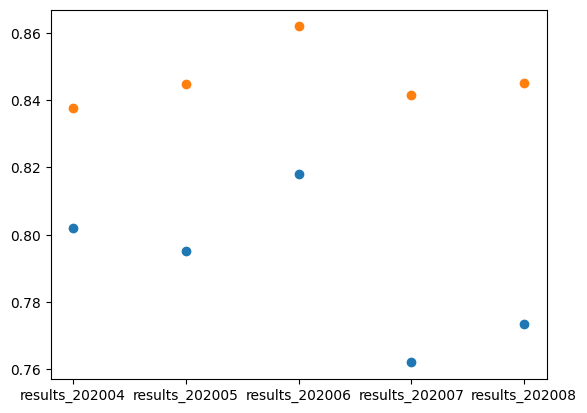

In [89]:
# モデル精度評価結果の推移
# GradientBooosting, テストデータに絞って休日/平日モデルともに可視化

score_all_gb = score_all.loc[(score_all['model_name']=='GradientBoosting')&(score_all['DataCategory']=='test')]
model_targets = score_all_gb['model_target'].unique()

import matplotlib.pyplot as plt

for model_target in model_targets:
    view_data = score_all_gb.loc[score_all_gb['model_target']==model_target]
    plt.scatter(view_data['dirs'], view_data['acc'])

結果を見ると、4月~6月までは精度向上が見られるが、7月に精度が低下している。  
7月で何か傾向が変わった可能性があると推測できる。